In [147]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from ocr.helpers import implt, resize, ratio
from ocr import page, words

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

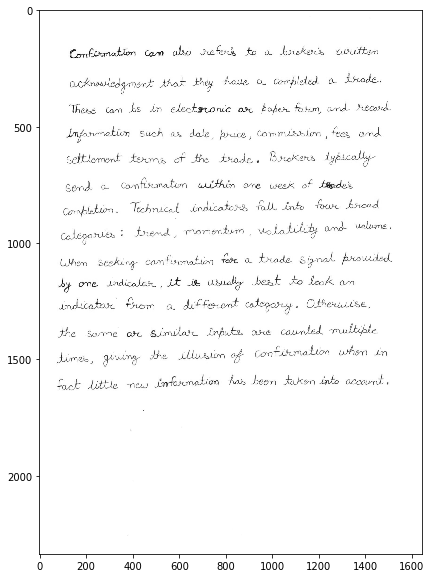

In [148]:
image = cv2.cvtColor(cv2.imread("../input/20.png"), cv2.COLOR_BGR2RGB)
image = page.detection(image)
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
implt(img, 'gray')

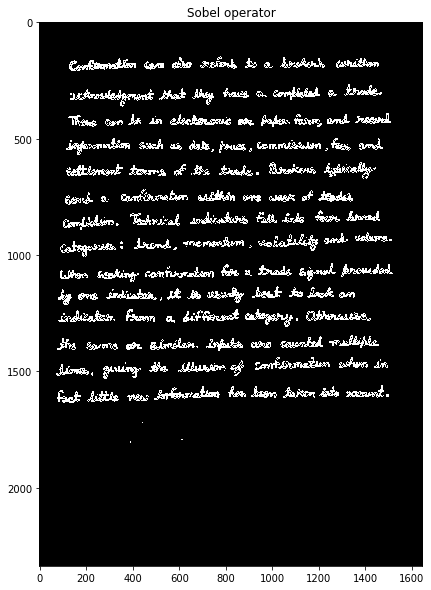

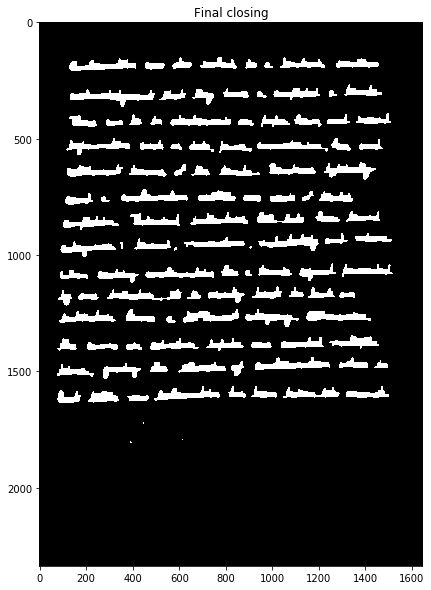

In [149]:
def sobel(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def edge_detect(im):
    """ 
    Edge detection 
    The Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([sobel(im[:,:, 0]), sobel(im[:,:, 1]), sobel(im[:,:, 2]) ]), axis=0)

# Image pre-processing - blur, edges, threshold, closing
blurred = cv2.GaussianBlur(image, (5, 5), 18)
edges = edge_detect(blurred)
ret, edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
bw_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((20,20), np.uint8))

implt(edges, 'gray', 'Sobel operator')
implt(bw_image, 'gray', 'Final closing')

In [150]:
def del_lines(gray):
    """ Delete page lines """
    linek = np.ones((1,11),np.uint8)
    x = cv2.morphologyEx(gray, cv2.MORPH_OPEN, linek ,iterations=1)
    i = gray-x
    closing = cv2.morphologyEx(dil, cv2.MORPH_CLOSE, np.ones((17,17), np.uint8))
    implt(closing, 'gray', 'Del Lines')
    return closing


def del_big_areas(img):
    """ Find and remove contours too big for a word """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # ret, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 3)    
    implt(gray, 'gray')
    
    gray2 = gray.copy()
    mask = np.zeros(gray.shape,np.uint8)
    
    im2, contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        if (200 < cv2.contourArea(cnt) < 5000):
            cv2.drawContours(img,[cnt],0,(0,255,0),2)
            cv2.drawContours(mask,[cnt],0,255,-1)
            
    implt(mask)
    implt(img)

In [151]:
def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return [x, y, w, h]

def intersect(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0:
        return False
    return True

def group_rectangles(rec):
    """
    Uion intersecting rectangles
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped ractangles 
    """
    tested = [False for i in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i+1
            while j < len(rec):
                if not tested[j] and intersect(rec[i], rec[j]):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1
            
    return final

In [152]:
def text_detect(img, original):
    """ Text detection using contours """
    # Resize image
    small = resize(img, 2000)
    image = resize(original, 2000)
    #small = img
    #image = original
    # Finding contours
    mask = np.zeros(small.shape, np.uint8)
    cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    implt(img, 'gray')
    
    # Variables for contour index and words' bounding boxes
    index = 0    
    boxes = []
    # CCOMP hierarchy: [Next, Previous, First Child, Parent]
    # cv2.RETR_CCOMP - contours into 2 levels
    # Go through all contours in first level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        # Get only the contour
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text (white pixel ratio, width, height)
        # TODO Test h/w and w/h ratios
        if r > 0.1 and 2000 > w > 10 and 1600 > h > 10 and h/w < 3 and w/h < 10:
            boxes += [[x, y, w, h]]
        
        # Index of next contour
        index = hierarchy[0][index][0]
        
    # Group intersecting rectangles
    boxes = group_rectangles(boxes)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y),(x+w,y+h), (0, 255, 0), 8)
        bounding_boxes = np.vstack((bounding_boxes, np.array([x, y, x+w, y+h])))


    implt(image, t='Bounding rectangles')
    # Recalculate coordinates to original scale
    boxes = bounding_boxes.dot(ratio(image, small.shape[0])).astype(np.int64)


    return boxes[1:]
    #return boxes

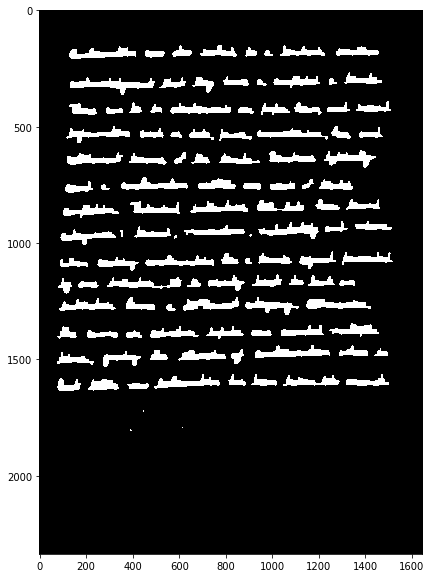

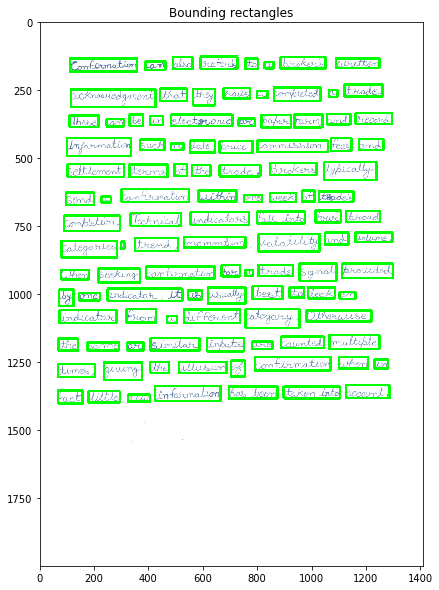

Number of boxes: 108


In [153]:
# Get text bounding boxes
boxes = text_detect(bw_image, image)
print("Number of boxes:", len(boxes))

In [154]:
boxes

array([[ 323, 1369,  404, 1395],
       [ 178, 1357,  293, 1399],
       [  66, 1354,  156, 1402],
       [ 896, 1340, 1104, 1383],
       [ 695, 1339,  874, 1384],
       [ 423, 1337,  664, 1393],
       [1125, 1335, 1286, 1382],
       [  65, 1257,  201, 1304],
       [ 234, 1251,  375, 1315],
       [ 405, 1250,  475, 1289],
       [ 510, 1249,  686, 1290],
       [ 702, 1244,  754, 1303],
       [1230, 1240, 1280, 1274],
       [1100, 1232, 1207, 1274],
       [ 791, 1231, 1069, 1281],
       [ 320, 1178,  380, 1207],
       [ 174, 1177,  291, 1207],
       [ 779, 1174,  855, 1201],
       [  67, 1163,  139, 1208],
       [ 613, 1162,  751, 1211],
       [ 406, 1162,  586, 1208],
       [ 886, 1156, 1045, 1199],
       [1064, 1150, 1248, 1202],
       [ 466, 1080,  503, 1107],
       [ 980, 1060, 1219, 1101],
       [  71, 1059,  281, 1106],
       [ 529, 1056,  736, 1106],
       [ 756, 1054,  954, 1124],
       [ 318, 1054,  427, 1105],
       [ 143,  996,  220, 1023],
       [11

In [155]:
lines = words.sort_words(boxes)

In [156]:
lines

[[array([110, 133, 357, 182]),
  array([387, 145, 461, 176]),
  array([489, 129, 561, 173]),
  array([590, 127, 726, 173]),
  array([755, 134, 801, 172]),
  array([826, 147, 859, 170]),
  array([ 885,  129, 1050,  171]),
  array([1089,  133, 1248,  169])],
 [array([113, 247, 425, 313]),
  array([441, 244, 541, 289]),
  array([562, 245, 643, 306]),
  array([674, 243, 773, 281]),
  array([797, 253, 837, 279]),
  array([ 860,  240, 1032,  289]),
  array([1062,  250, 1094,  275]),
  array([1120,  229, 1260,  273])],
 [array([108, 343, 214, 386]),
  array([244, 356, 309, 383]),
  array([328, 339, 378, 381]),
  array([405, 345, 453, 379]),
  array([482, 340, 707, 381]),
  array([730, 355, 790, 382]),
  array([814, 341, 922, 388]),
  array([ 936,  339, 1038,  387]),
  array([1056,  338, 1141,  376]),
  array([1161,  334, 1294,  375])],
 [array([ 98, 425, 335, 492]),
  array([368, 432, 458, 470]),
  array([482, 446, 527, 471]),
  array([551, 435, 643, 480]),
  array([660, 437, 782, 482]),
  ar

In [157]:
image = cv2.cvtColor(cv2.imread("../input/20.png"), cv2.COLOR_BGR2RGB)
image = page.detection(image)
imLines = []
for line in lines:
    imLine = []
    for words in line: 
        (x1, y1, x2, y2) = words
        currImg = image[y1:y2, x1:x2]
        imLine.append(currImg)
    imLines.append(imLine)

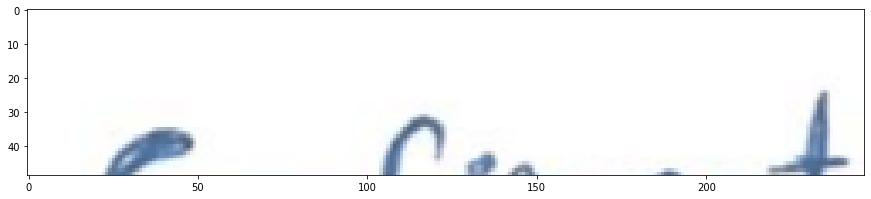

In [159]:
implt(imLines[0][0])

In [39]:
boxes = sorted(boxes, key=lambda entry: (entry[1],entry[0]))

In [100]:
boxes

[[690, 149, 158, 52],
 [572, 151, 83, 50],
 [1034, 151, 192, 48],
 [129, 156, 288, 56],
 [1273, 156, 185, 41],
 [883, 157, 52, 43],
 [453, 170, 85, 35],
 [966, 172, 37, 26],
 [1309, 268, 162, 50],
 [1005, 281, 200, 56],
 [788, 284, 114, 44],
 [516, 286, 116, 51],
 [657, 287, 94, 70],
 [132, 289, 364, 76],
 [1241, 292, 37, 29],
 [932, 296, 45, 29],
 [1357, 391, 154, 47],
 [1234, 395, 99, 44],
 [384, 396, 57, 48],
 [1094, 396, 118, 56],
 [563, 398, 262, 47],
 [952, 399, 125, 54],
 [127, 401, 122, 49],
 [474, 403, 55, 39],
 [853, 415, 69, 31],
 [286, 416, 74, 31],
 [115, 497, 276, 77],
 [1252, 498, 85, 55],
 [1371, 501, 104, 49],
 [430, 505, 104, 44],
 [934, 508, 304, 49],
 [644, 509, 107, 51],
 [772, 511, 141, 52],
 [563, 521, 52, 29],
 [1221, 602, 225, 75],
 [988, 604, 200, 51],
 [578, 609, 53, 52],
 [118, 610, 242, 54],
 [384, 613, 163, 51],
 [652, 615, 80, 45],
 [772, 615, 174, 47],
 [351, 717, 287, 55],
 [681, 723, 162, 47],
 [1127, 724, 51, 46],
 [1199, 727, 148, 45],
 [113, 733, 11

In [104]:
lines = []
line = [boxes[0]]
for c in boxes[1:]:
    if c[1] - line[-1][1] < 50:
        line.append(c)
    else:
        lines.append(sorted(line, key=lambda entry: entry[0]))
        line = [c]
lines.append(sorted(line, key=lambda entry: entry[0]))
        

In [105]:
for i in lines:
    print(len(i))

8
8
10
8
7
8
6
8
8
9
6
8
8
7


In [106]:
imLines = []
for line in lines:
    imLine = []
    for words in line: 
        (x, y, w, h) = words
        currImg = img[y:y+h-4, x:x+w]
        imLine.append(currImg)
    imLines.append(imLine)

In [107]:
len(imLines)




14

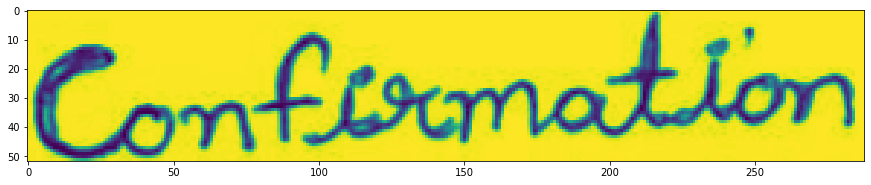

In [96]:
implt(imLines[0][0])

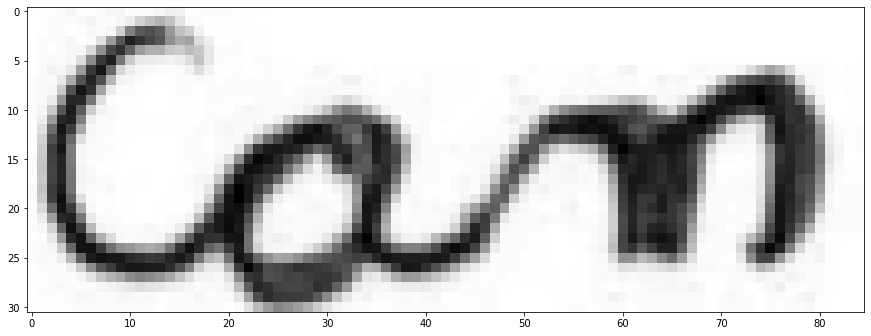

In [97]:
implt(imLines[0][1],'gray')

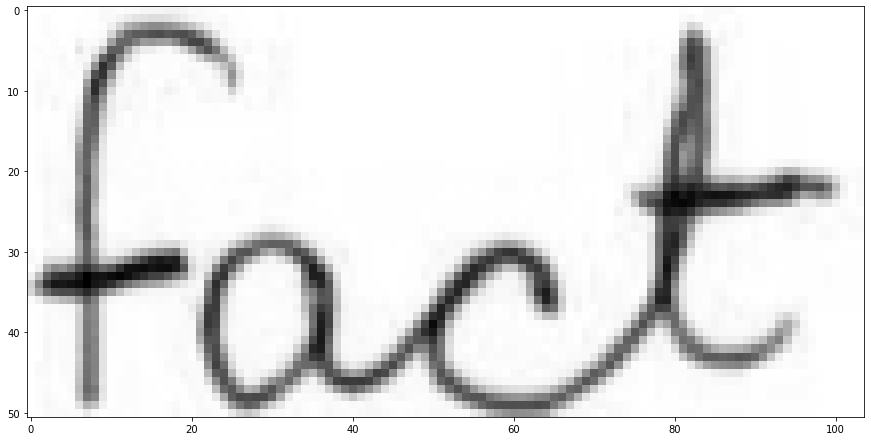

In [108]:
implt(imLines[-1][0],'gray')

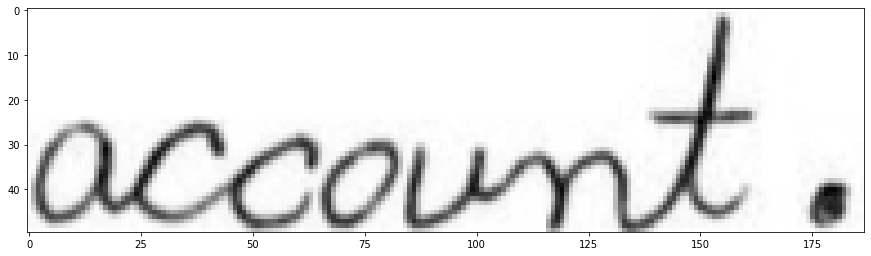

In [99]:
implt(currImg, 'gray')

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from ocr.normalization import word_normalization, letter_normalization
from ocr import page, words
from ocr.helpers import implt, resize
from ocr.tfhelpers import Model
from ocr.datahelpers import idx2char

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

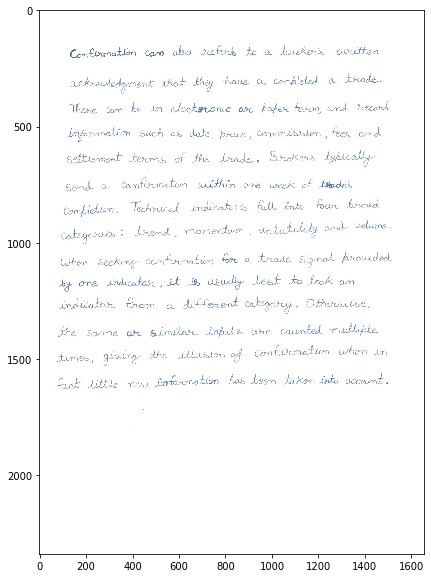

In [3]:
image = cv2.cvtColor(cv2.imread("../input/20.png"), cv2.COLOR_BGR2RGB)
implt(image)

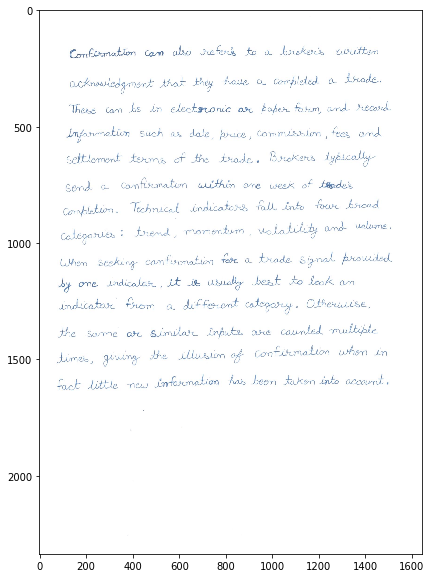

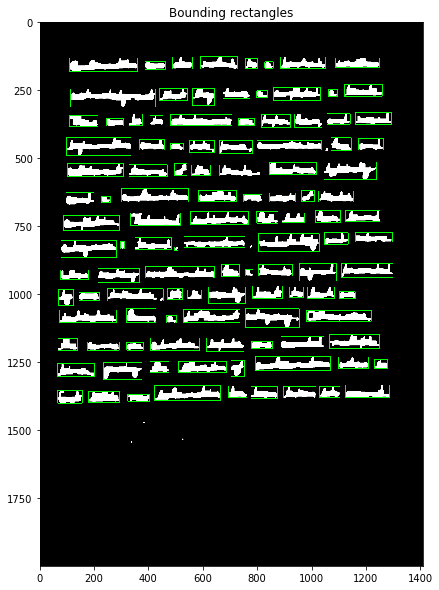

In [4]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
boxes = words.detection(crop)
lines = words.sort_words(boxes)

In [5]:
imLines=[]
for line in lines:
    imLine=[]
    for (x1, y1, x2, y2) in line:
        imLine.append(crop[y1:y2, x1:x2])
    imLines.append(imLine)

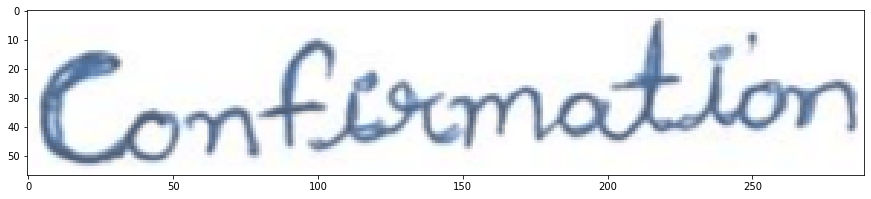

In [6]:
implt(imLines[0][0],'gray')